In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
# Load CSV files
train_df = pd.read_csv('/kaggle/input/lacuna-malaria-detection-dataset/Train.csv')
test_df = pd.read_csv('/kaggle/input/lacuna-malaria-detection-dataset/Test.csv')

In [3]:
# Set the image directory
img_dir = '/kaggle/input/lacuna-malaria-detection-dataset/images/'

# Create image paths for training data
train_df['image_path'] = train_df['Image_ID'].apply(lambda x: os.path.join(img_dir, x))

# Split training data into train and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['class'])

# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalization
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

# Only rescaling for validation and test data
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle= True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_data,
    x_col='image_path',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False
)

# Prepare test data
test_df['image_path'] = test_df['Image_ID'].apply(lambda x: os.path.join(img_dir, x))
test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

# Print some information about the data
print(f"Number of classes: {len(train_generator.class_indices)}")
print(f"Number of training samples: {len(train_generator)}")
print(f"Number of validation samples: {len(val_generator)}")
print(f"Number of test samples: {len(test_generator)}")

# Check class balance
print("\nClass distribution in training data:")
print(train_data['class'].value_counts(normalize=True))
print("\nClass distribution in validation data:")
print(val_data['class'].value_counts(normalize=True))

Found 18824 validated image filenames belonging to 3 classes.
Found 4706 validated image filenames belonging to 3 classes.
Found 1178 validated image filenames.
Number of classes: 3
Number of training samples: 589
Number of validation samples: 148
Number of test samples: 37

Class distribution in training data:
class
Trophozoite    0.673077
WBC            0.297652
NEG            0.029271
Name: proportion, dtype: float64

Class distribution in validation data:
class
Trophozoite    0.673183
WBC            0.297705
NEG            0.029112
Name: proportion, dtype: float64


# Explore the Data

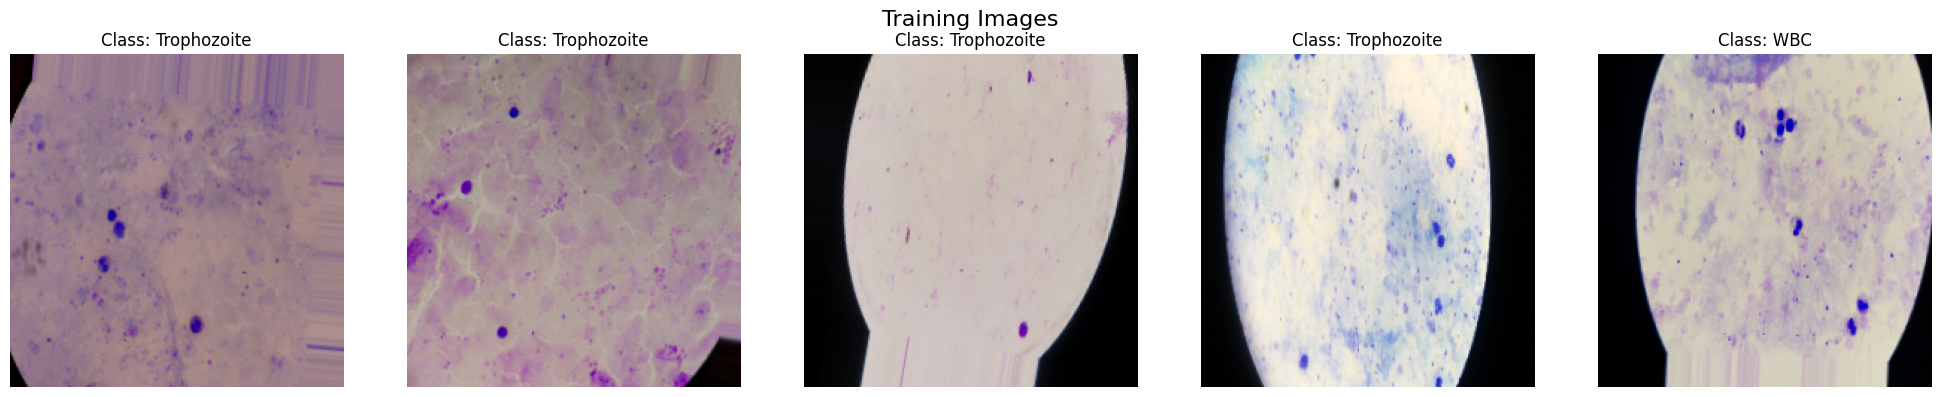

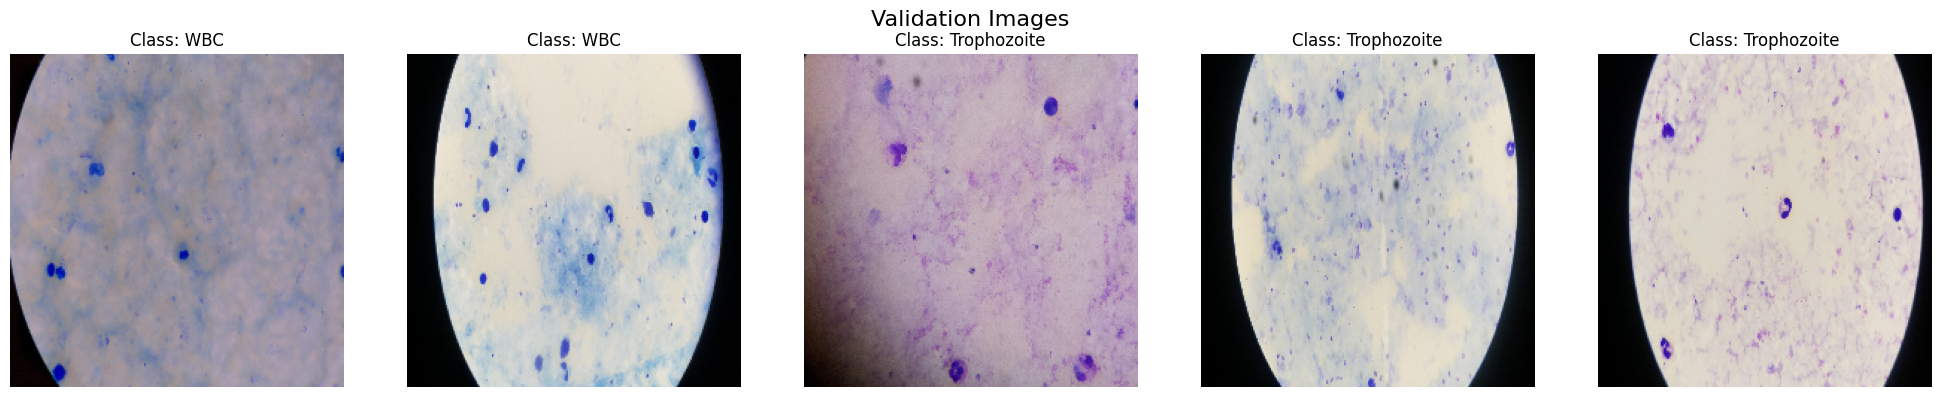

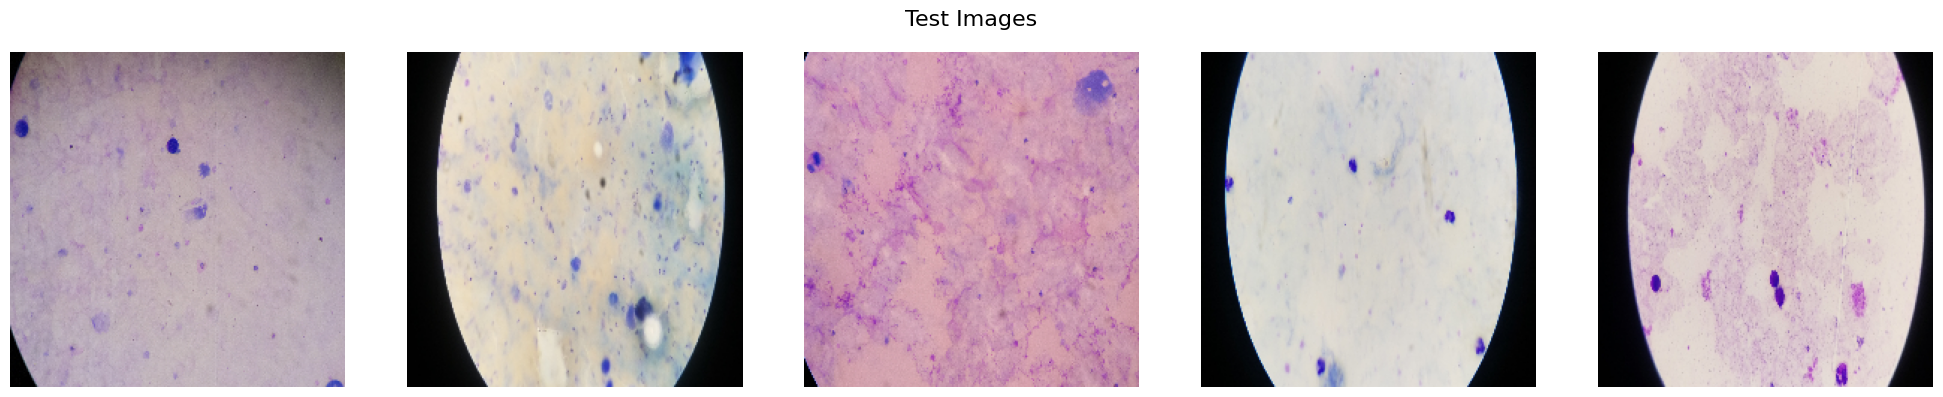

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def plot_images(generator, title, n=5):
    plt.figure(figsize=(20, 4))
    plt.suptitle(title, fontsize=16)
    
    # Check if the generator has class information
    has_classes = hasattr(generator, 'class_indices')
    
    if has_classes:
        # Get the class indices
        class_indices = generator.class_indices
        # Invert the dictionary to map indices to class names
        index_to_class = {v: k for k, v in class_indices.items()}
    
    for i in range(n):
        # Get a batch of images
        batch = next(generator)
        
        # For train and validation, batch is a tuple (images, labels)
        # For test, batch is just images
        if isinstance(batch, tuple):
            images, labels = batch
        else:
            images = batch
        
        # Select a random image from the batch
        idx = np.random.randint(0, images.shape[0])
        img = images[idx]
        
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        
        if has_classes and isinstance(batch, tuple):
            label_idx = np.argmax(labels[idx])
            class_name = index_to_class[label_idx]
            plt.title(f"Class: {class_name}")
    
    plt.tight_layout()
    plt.show()

# Visualize training images
plot_images(train_generator, "Training Images")

# Visualize validation images
plot_images(val_generator, "Validation Images")

# Visualize test images
plot_images(test_generator, "Test Images")


# Define the model

In [5]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
# Define the model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [7]:
steps_per_epoch = len(train_data) // batch_size

In [9]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(3, activation='softmax')
])

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Train the model with frozen base
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_frozen = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=None,
    callbacks=[early_stopping],
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


588/588 ━━━━━━━━━━━━━━━━━━━━ 1680s 3s/step - accuracy: 0.6720 - loss: 0.7826 - val_accuracy: 0.6732 - val_loss: 0.7328
Epoch 2/10
  1/588 ━━━━━━━━━━━━━━━━━━━━ 11:37 1s/step - accuracy: 0.7188 - loss: 0.7000

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


588/588 ━━━━━━━━━━━━━━━━━━━━ 270s 458ms/step - accuracy: 0.7188 - loss: 0.7000 - val_accuracy: 0.6732 - val_loss: 0.7325
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 1599s 3s/step - accuracy: 0.6711 - loss: 0.7350 - val_accuracy: 0.6732 - val_loss: 0.7311
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 265s 449ms/step - accuracy: 0.6875 - loss: 0.6480 - val_accuracy: 0.6732 - val_loss: 0.7313
Epoch 5/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 1697s 3s/step - accuracy: 0.6755 - loss: 0.7258 - val_accuracy: 0.6732 - val_loss: 0.7306
Epoch 6/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 277s 469ms/step - accuracy: 0.5938 - loss: 0.8048 - val_accuracy: 0.6732 - val_loss: 0.7304
Epoch 7/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 1674s 3s/step - accuracy: 0.6719 - loss: 0.7322 - val_accuracy: 0.6732 - val_loss: 0.7300
Epoch 8/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 284s 482ms/step - accuracy: 0.6875 - loss: 0.6502 - val_accuracy: 0.6732 - val_loss: 0.7300
Epoch 9/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 1654s 3s/step - accuracy: 0.6787 - loss: 0.7263 - val

In [12]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [13]:
# Recompile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with unfrozen layers
history_unfrozen = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=None,
    callbacks=[early_stopping]
)

Epoch 1/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 1710s 3s/step - accuracy: 0.6614 - loss: 0.7624 - val_accuracy: 0.6732 - val_loss: 0.7355
Epoch 2/10
  1/588 ━━━━━━━━━━━━━━━━━━━━ 14:01 1s/step - accuracy: 0.7188 - loss: 0.6224

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


588/588 ━━━━━━━━━━━━━━━━━━━━ 269s 456ms/step - accuracy: 0.7188 - loss: 0.6224 - val_accuracy: 0.6732 - val_loss: 0.7360
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 1671s 3s/step - accuracy: 0.6718 - loss: 0.7372 - val_accuracy: 0.6732 - val_loss: 0.7335


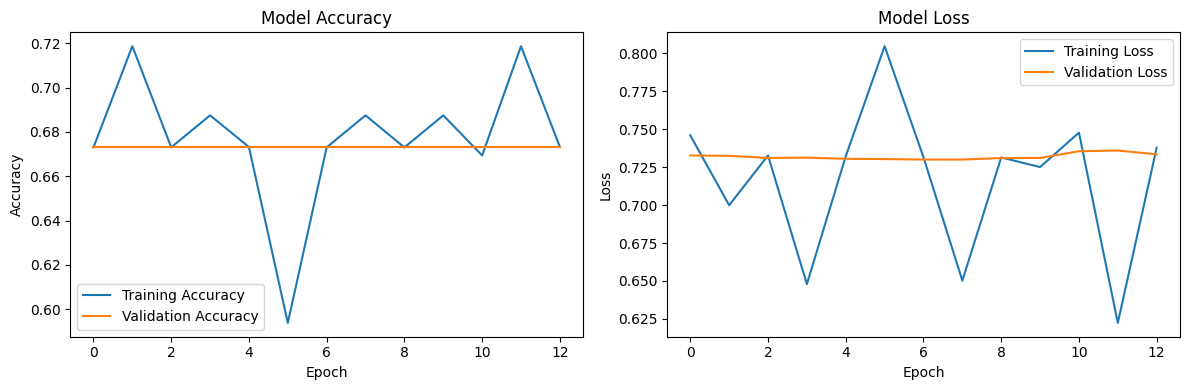

In [14]:
# Combine histories
history = {}
history['accuracy'] = history_frozen.history['accuracy'] + history_unfrozen.history['accuracy']
history['val_accuracy'] = history_frozen.history['val_accuracy'] + history_unfrozen.history['val_accuracy']
history['loss'] = history_frozen.history['loss'] + history_unfrozen.history['loss']
history['val_loss'] = history_frozen.history['val_loss'] + history_unfrozen.history['val_loss']

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(val_generator)
print(f"Test accuracy: {test_accuracy:.4f}")

148/148 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.6768 - loss: 0.7251
Test accuracy: 0.6732


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


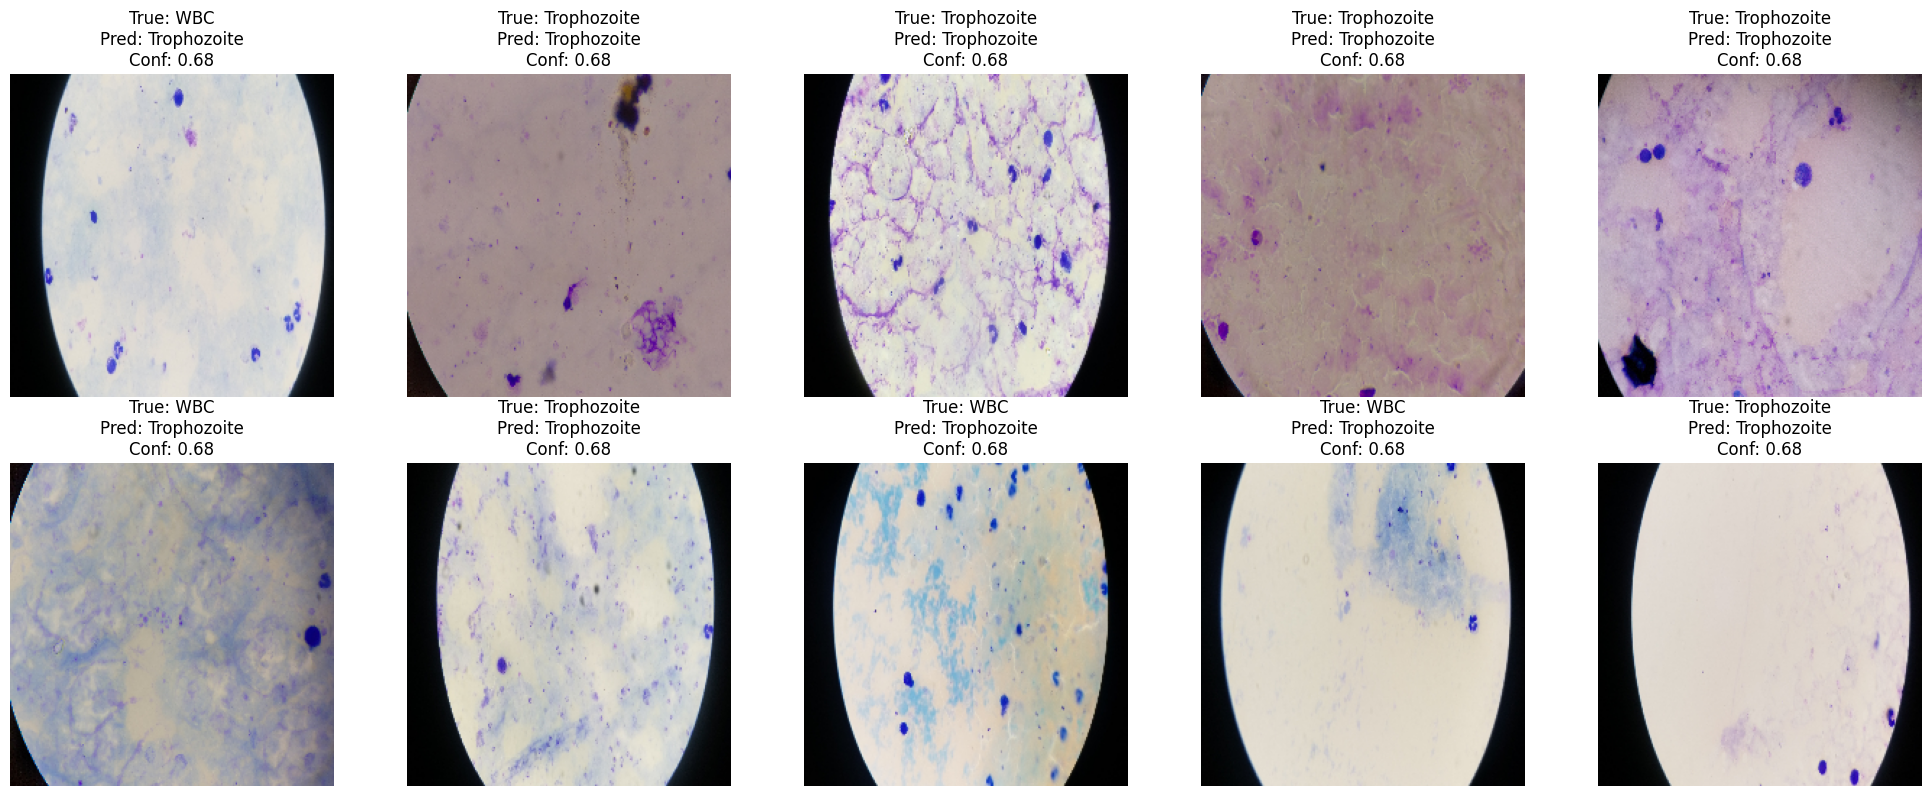

In [17]:
import random

def plot_sample_predictions(model, val_generator, val_data, num_samples=10):
    # Get a batch of validation data
    batch_x, batch_y = next(val_generator)
    
    # Get predictions
    predictions = model.predict(batch_x)
    
    # Get class labels
    class_labels = list(val_generator.class_indices.keys())
    
    # Randomly select samples
    indices = random.sample(range(len(batch_x)), num_samples)
    
    # Plot the samples
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        # Get the image and its true label
        img = batch_x[idx]
        true_label = class_labels[np.argmax(batch_y[idx])]
        
        # Get the predicted label and confidence
        pred_label = class_labels[np.argmax(predictions[idx])]
        confidence = np.max(predictions[idx])
        
        # Plot the image
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}")
    
    plt.tight_layout()
    plt.show()

# Use the function
plot_sample_predictions(model, val_generator, val_data)

# Prediction on Test Data

In [18]:
# Get predictions
predictions = model.predict(test_generator, steps=len(test_df) // batch_size + 1)

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Create a DataFrame with predictions
results_df = pd.DataFrame({
    'Image_ID': test_df['Image_ID'],
    'Predicted_Class': [class_labels[np.argmax(pred)] for pred in predictions],
    'Confidence': [np.max(pred) for pred in predictions]
})

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step


In [21]:
results_df.head()

Image_ID Predicted_Class  Confidence
0  id_5n9ov0rr22.jpg     Trophozoite    0.682445
1  id_k6s11k3klo.jpg     Trophozoite    0.682599
2  id_eftvcf9djb.jpg     Trophozoite    0.682303
3  id_kc5tmoj1xa.jpg     Trophozoite    0.682692
4  id_tirid4qt68.jpg     Trophozoite    0.681797